In [1]:
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch
import torch.nn as nn
import textwrap
import yaml



# === Torch device setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

with open("/home/houtlaw/iono-net/model/config_ynet.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# === Matplotlib Settings ===
plt.rcParams.update({'font.size': 22})
rcParams["figure.figsize"] = (40, 10)
plt.rcParams["savefig.dpi"] = 300

# === Parameters ===
SAMPLE_IDX = 0
DX = 0.25
zero_pad = 50
ZOOM_RADIUS = 50
ISLR_RADIUS = 5
ISLR_RADIUS_RATIO = 0.6
ISLR_MAIN_LOBE_WIDTH = 0.75
FILENAME_PREFIX = "torch_eval"
DATA_DIR = "/home/houtlaw/iono-net/data/aug25"
MODEL_WEIGHTS_PATH = "/home/houtlaw/iono-net/model/ynet_focus_weights.pkl"
PLOT_DIR = "visualization_outputs"
os.makedirs(PLOT_DIR, exist_ok=True)

# === File Paths ===
X_RANGE_PATH = f"{DATA_DIR}/meta_X_20250707_155325.csv"
SETUP_PATH = f"{DATA_DIR}/setup_20250707_155325.json"
SCATTERER_PATH = f"{DATA_DIR}/train_nuStruct_withSpeckle_20250707_155301.csv"
SIGNAL_PATH = f"{DATA_DIR}/train_uscStruct_vals_20250707_155313.csv"
KPSI_PATH = f"{DATA_DIR}/kPsi_20250707_155325.csv"
PSI_COEFFS_PATH = f"{DATA_DIR}/train_compl_ampls_20250707_155312.csv"

 #=== Helper Functions ===
def convert_to_complex(s):
    s = str(s)
    if s == "NaNNaNi":
        return 0
    return complex(s.replace('i', 'j'))

def normalize_complex_to_unit_range(matrix):
    amp = np.abs(matrix)
    amp_max = np.max(amp, axis=1, keepdims=True)
    amp_max[amp_max == 0] = 1
    return matrix / amp_max

def split_complex_to_imaginary(complex_array):
    return np.concatenate([complex_array.real, complex_array.imag], axis=-1)

def compute_image_integral_torch(x_range, signal_vals, model_output_complex, kpsi_values, F, dx, xi=0.5):
    device = model_output_complex.device
    domain = torch.tensor(x_range, dtype=torch.float64, device=device)
    real_signal = torch.tensor(signal_vals[0], dtype=torch.float64, device=device)
    complex_signal = torch.tensor(signal_vals[1], dtype=torch.cfloat, device=device)
    cosAmps = model_output_complex.real
    sinAmps = -model_output_complex.imag
    wavenums = torch.tensor(kpsi_values, dtype=torch.float64, device=device)

    def calc_psi(sarr):
        wavenum_sarr = torch.outer(sarr, wavenums)
        cosAmp_mat = cosAmps.unsqueeze(0)
        sinAmp_mat = sinAmps.unsqueeze(0)
        cos_terms = torch.cos(wavenum_sarr) * cosAmp_mat
        sin_terms = torch.sin(wavenum_sarr) * sinAmp_mat
        return torch.sum(cos_terms + sin_terms, dim=1)

    image_vals = []
    for y in domain:
        y = y.item()
        x0 = torch.max(real_signal[0], torch.tensor(y - F / 2, dtype=torch.float64, device=device))
        x1 = torch.min(real_signal[-1], torch.tensor(y + F / 2, dtype=torch.float64, device=device))
        mask = (real_signal >= x0) & (real_signal <= x1)
        base = real_signal[mask]
        signal_segment = complex_signal[mask]
        if base.numel() == 0:
            image_vals.append(torch.tensor(0.0, dtype=torch.cfloat, device=device))
            continue
        waveform = torch.exp(-1j * torch.pi * (base - y) ** 2 / F)
        sarr = xi * base + (1 - xi) * y
        psi_vals = torch.exp(1j * calc_psi(sarr))
        integrand = waveform * signal_segment * psi_vals
        integral = torch.trapz(integrand, base) / F
        image_vals.append(integral)
    return torch.stack(image_vals)

def compute_islr(image_integral, known_scatterers, x_vals, radius, radius_ratio, main_lobe_width, dx):
    islrs = []
    peaks = [x_vals[i] for i, scatterer in enumerate(known_scatterers) if scatterer > 2]
    image_integral = image_integral ** 2
    for peak in peaks:
        inner_indices = [i for i, x in enumerate(x_vals) if abs(x - peak) <= main_lobe_width]
        outer_indices = [i for i, x in enumerate(x_vals) if main_lobe_width < abs(x - peak) <= (radius * radius_ratio)]
        if not inner_indices or not outer_indices:
            continue
        inner_integral = np.trapz(image_integral[inner_indices], x_vals[inner_indices])
        outer_integral = np.trapz(image_integral[outer_indices], x_vals[outer_indices])
        islr = 10 * np.log10(outer_integral / inner_integral) if inner_integral != 0 else 0
        islrs.append(islr)
    return np.mean(islrs)

x_range = pd.read_csv(X_RANGE_PATH).iloc[:, 0].values
setup = json.load(open(SETUP_PATH))
F, xi = setup["F"], setup["xi"]
kpsi_values = pd.read_csv(KPSI_PATH, header=None).values.flatten()
setup_str = ", ".join(f"{k}={v}" for k, v in setup.items())
wrapped_setup = textwrap.fill(setup_str, width=180)

scatterer_mag = pd.read_csv(SCATTERER_PATH).map(convert_to_complex).iloc[:, SAMPLE_IDX].map(np.abs).values
signal_data = pd.read_csv(SIGNAL_PATH).map(convert_to_complex).T.iloc[SAMPLE_IDX].values
psi_coeffs_vals = pd.read_csv(PSI_COEFFS_PATH).T.map(lambda x: complex(x.replace('i', 'j'))).iloc[SAMPLE_IDX].values

signal_data = normalize_complex_to_unit_range(signal_data[None, :])[0]


Using device: cuda


yb_vals.shape: (1341,)
u_yb_vals.shape: (1341,)


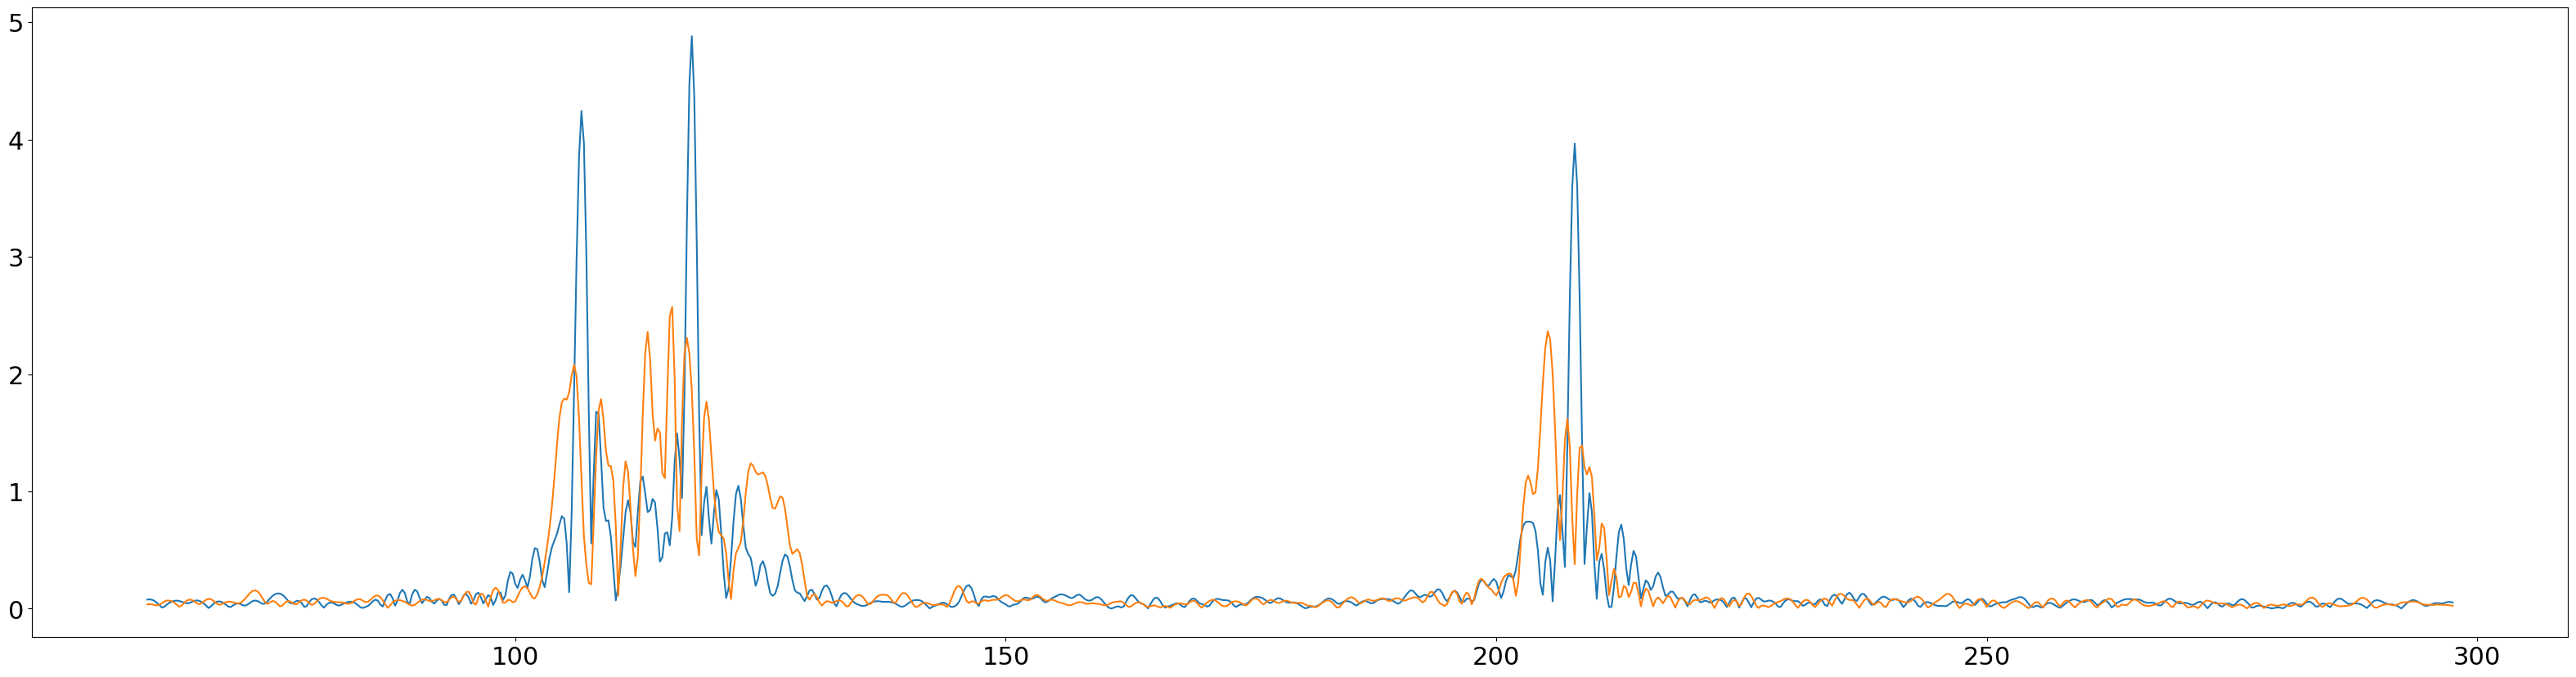

In [3]:
x_range_trunc = x_range[4 * zero_pad : -4 * zero_pad]

# Load true focused image (yb)
true_img_path = cfg["paths"]["focused_train"]
yb_vals = pd.read_csv(true_img_path).values[SAMPLE_IDX]
print("yb_vals.shape:", yb_vals.shape)
yb_mag = np.abs(np.array([convert_to_complex(x) for x in yb_vals]))/ DX


# Load unfocused image from dataset
unfoc_img_path = cfg["paths"]["unfocused_train"]
u_yb_vals = pd.read_csv(unfoc_img_path).values[SAMPLE_IDX]
print("u_yb_vals.shape:", u_yb_vals.shape)
u_yb_mag = np.abs(np.array([convert_to_complex(x) for x in u_yb_vals]))/ DX

plt.plot(x_range_trunc[zero_pad:-zero_pad], yb_mag[4*zero_pad:-4*zero_pad])
plt.plot(x_range_trunc[zero_pad:-zero_pad], u_yb_mag[4*zero_pad:-4*zero_pad])

/tmp/ipykernel_925233/3051470936.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  domain = torch.tensor(x_range, dtype=torch.float64, device=device)
/tmp/ipykernel_925233/3051470936.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_signal = torch.tensor(signal_vals[0], dtype=torch.float64, device=device)
/tmp/ipykernel_925233/3051470936.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  complex_signal = torch.tensor(signal_vals[1], dtype=torch.cfloat, device=device)
/tmp/ipykernel_925233/3051470936.py:73: UserWarning: To cop

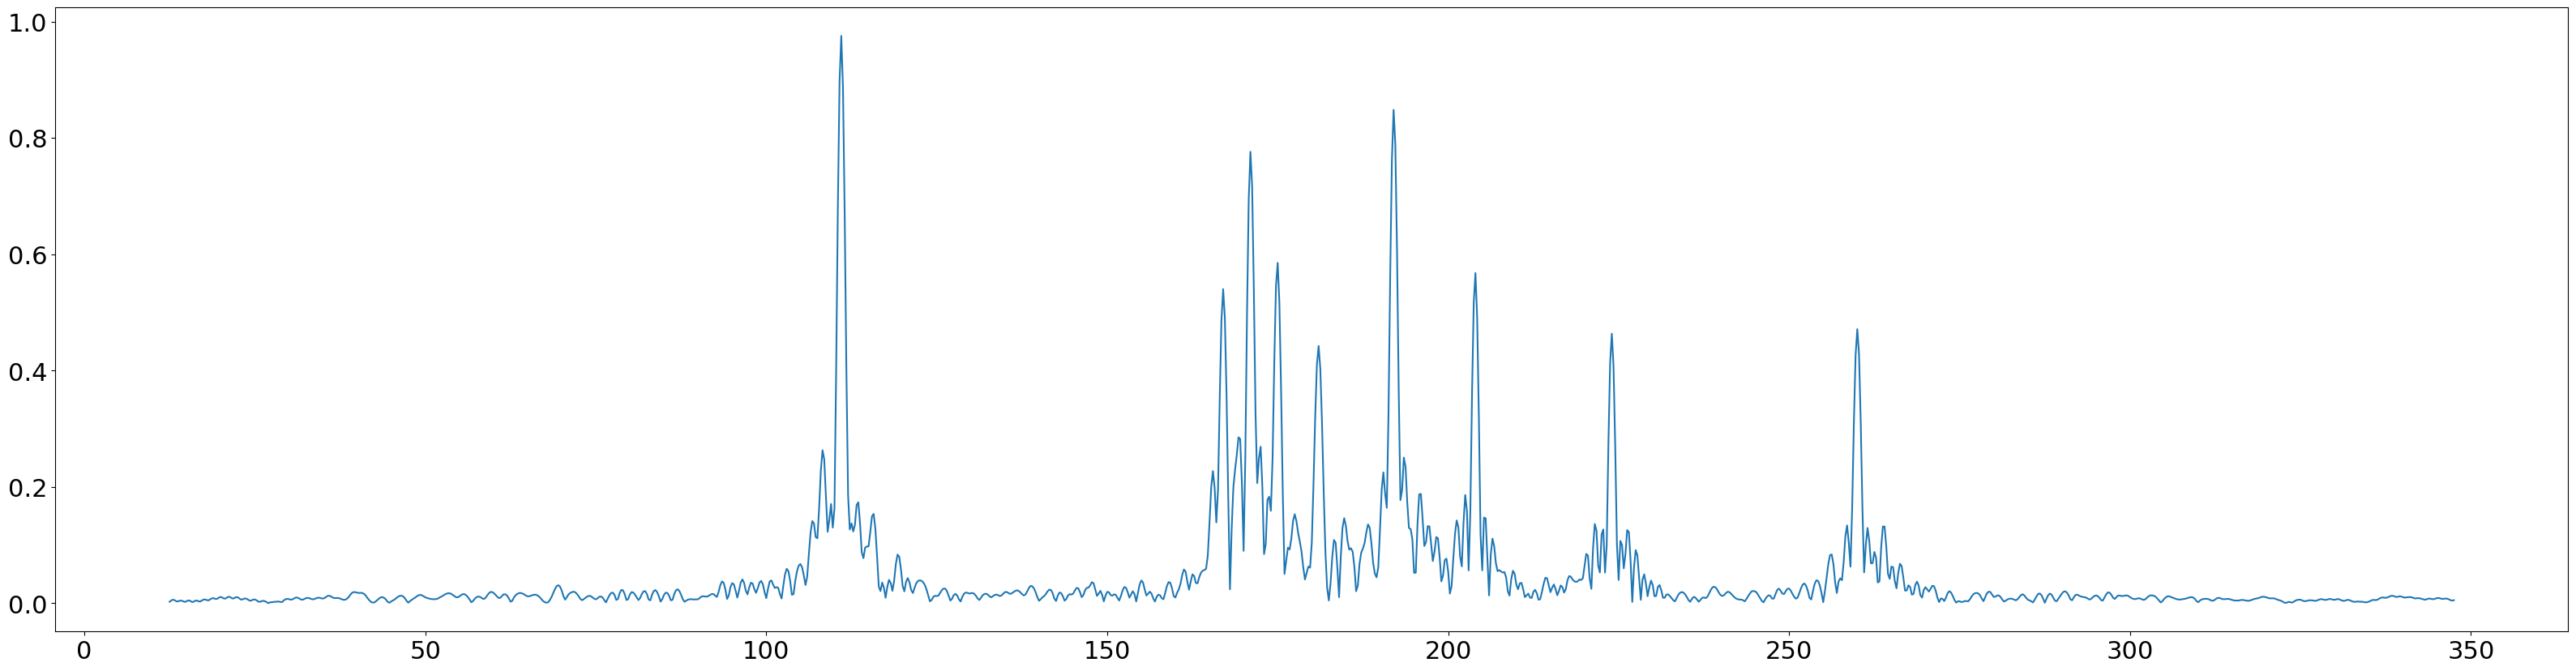

In [ ]:
x_range_trunc = torch.tensor(x_range, dtype=torch.float64, device=device)  # replace with truncated version if needed
signal_tensor_real = torch.tensor(signal_data.real, dtype=torch.float64, device=device)
signal_tensor_imag = torch.tensor(signal_data.imag, dtype=torch.float64, device=device)
signal_tensor = torch.complex(signal_tensor_real, signal_tensor_imag)
signal_vals = (x_range_trunc, signal_tensor)

model_output_complex = torch.tensor(psi_coeffs_vals, dtype=torch.cfloat, device=device)
kpsi_tensor = torch.tensor(kpsi_values, dtype=torch.float64, device=device)
F_scalar = torch.tensor(F, dtype=torch.float64, device=device)
dx_scalar = torch.tensor(DX, dtype=torch.float64, device=device)

true_focus = compute_image_integral_torch(
    x_range_trunc,
    signal_vals,
    model_output_complex,
    kpsi_tensor,
    F_scalar,
    dx_scalar,
    xi=xi
)

true_abs = np.abs(np.array([x for x in true_focus.cpu().numpy()]))/ DX
#plt.plot(x_range_trunc[5*zero_pad:-5*zero_pad].cpu().numpy(), yb_mag)
plt.plot(x_range_trunc[zero_pad:-zero_pad].cpu().numpy(), true_abs[zero_pad:-zero_pad])